In [ ]:
# import necesarry packages

import collections
import folium
import json
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string
import pickle
# from surprise import Reader , Dataset
from tabulate import tabulate
# from surprise.model_selection import cross_validate
# from surprise.prediction_algorithms import SVD
# from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
# from surprise.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models ,layers, optimizers , losses, regularizers, metrics
from wordcloud import WordCloud


# plotting styles
plt.style.use("fivethirtyeight")
%matplotlib inline

In [ ]:
# load the businesses dataset
business= pd.read_csv("business.csv")
# preview the datasetdata.loc[ data.categories.str.contains('Restaurants')]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
# view the datasets features/columns
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   54380 non-null  object 
 1   name          54380 non-null  object 
 2   address       52551 non-null  object 
 3   city          54380 non-null  object 
 4   state         54380 non-null  object 
 5   postal_code   54360 non-null  object 
 6   latitude      54380 non-null  float64
 7   longitude     54380 non-null  float64
 8   stars         54380 non-null  float64
 9   review_count  54380 non-null  int64  
 10  is_open       54380 non-null  int64  
 11  attributes    49543 non-null  object 
 12  categories    54342 non-null  object 
 13  hours         45975 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 5.8+ MB


In [ ]:
# loadi the second dataset review.csv
review=pd.read_csv("review.csv")
# preview the dataset
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [ ]:
# view the datasets features/columns
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    54380 non-null  object 
 1   user_id      54380 non-null  object 
 2   business_id  54380 non-null  object 
 3   stars        54380 non-null  float64
 4   useful       54380 non-null  int64  
 5   funny        54380 non-null  int64  
 6   cool         54380 non-null  int64  
 7   text         54380 non-null  object 
 8   date         54380 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.7+ MB


In [ ]:
# merge the two datasets into one using the business_id primary key

data=pd.merge(left=review , right=business, how='left', on='business_id')

# preview the new merge dataset
data.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': ""u'average'"", 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,...,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",NaN
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


In [ ]:
# preview the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54380 entries, 0 to 54379
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_id     54380 non-null  object 
 1   user_id       54380 non-null  object 
 2   business_id   54380 non-null  object 
 3   stars_x       54380 non-null  float64
 4   useful        54380 non-null  int64  
 5   funny         54380 non-null  int64  
 6   cool          54380 non-null  int64  
 7   text          54380 non-null  object 
 8   date          54380 non-null  object 
 9   name          54380 non-null  object 
 10  address       53926 non-null  object 
 11  city          54380 non-null  object 
 12  state         54380 non-null  object 
 13  postal_code   54380 non-null  object 
 14  latitude      54380 non-null  float64
 15  longitude     54380 non-null  float64
 16  stars_y       54380 non-null  float64
 17  review_count  54380 non-null  int64  
 18  is_open       54380 non-nu

In [ ]:
data.describe()

,stars_x,useful,funny,cool,latitude,longitude,stars_y,review_count,is_open
count,54380.000000,54380.000000,54380.000000,54380.000000,54380.000000,54380.000000,54380.000000,54380.000000,54380.000000
mean,3.844980,0.890438,0.253567,0.346396,36.050556,-89.005350,3.769796,389.177014,0.766532
std,1.352256,1.866532,1.035998,1.073067,5.289909,14.446695,0.671340,628.925711,0.423041
min,1.000000,0.000000,0.000000,0.000000,27.584300,-120.026076,1.000000,5.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,29.967159,-90.239235,3.500000,61.000000,1.000000
50%,4.000000,0.000000,0.000000,0.000000,38.612534,-86.252569,4.000000,170.000000,1.000000
75%,5.000000,1.000000,0.000000,0.000000,39.946685,-75.325252,4.000000,430.000000,1.000000
max,5.000000,91.000000,98.000000,49.000000,53.644501,-74.658572,5.000000,4554.000000,1.000000


In [ ]:
data.rename(columns={'stars_x':'rating', 'stars_y':'b/s_rating'}, inplace=True)
# check for columns with missing values
data.isna().sum()

data['address'] = data['address'].fillna("Not-Available")
data['attributes'] = data['attributes'].fillna("Not-Available")
data['categories'] = data['categories'].fillna("Not-Available")
data['hours'] = data['hours'].fillna("Not-Available")


# preview our changes
data.isna().sum()

# check for duplicated columns
print("Duplicates: ",data.duplicated().sum())

Duplicates:  0


In [ ]:
# combine the address columns
data['location']=data[['city','state','address']]\
            .apply( lambda x: f"State:{x['state']}, City:{x['city']}, Address:{x['address']} ", axis=1)

# we drop the combined columns
data.drop(columns=['state', 'city','address'], axis=1, inplace=True)

data.location

,location
0,"State:PA, City:North Wales, Address:1460 Bethl..."
1,"State:PA, City:Philadelphia, Address:1923 Ches..."
2,"State:AZ, City:Tucson, Address:748 W Starr Pas..."
3,"State:PA, City:Philadelphia, Address:2481 Gran..."
4,"State:LA, City:New Orleans, Address:2549 Banks..."
...,...
54375,"State:ID, City:Boise, Address:590 E Boise Ave"
54376,"State:MO, City:Saint Louis, Address:1 S Broadway"
54377,"State:CA, City:Santa Barbara, Address:119 E Co..."
54378,"State:LA, City:New Orleans, Address:1418 Magaz..."


In [ ]:
# convert the user_id into intergers

# select only the unique user ids as a dataframe
ids=data[['user_id']].drop_duplicates('user_id').reset_index(drop=True).copy()

# reset the indexes, to include a continous numbering
ids=ids.reset_index()

# merge the ids dataframe with our original dataframe using the user id column as primary key
# rename the index column to represent the user ids
data=pd.merge(data,ids, how='left', on='user_id').drop('user_id', axis=1).rename(columns={'index':'user_id'})

# write a function to order the user ids to start from 1 instead of '0'
def add(x):
    """ adds 1 to the existing user id"""
    y=x+1
    return y
data.user_id=data.user_id.apply(add )  # apply the function to our user ids
data.head()

,review_id,business_id,rating,useful,funny,cool,text,date,name,postal_code,latitude,longitude,b/s_rating,review_count,is_open,attributes,categories,hours,location,user_id
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': ""u'average'"", 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","State:PA, City:North Wales, Address:1460 Bethl...",1
1,BiTunyQ73aT9WBnpR9DZGw,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...","State:PA, City:Philadelphia, Address:1923 Ches...",2
2,saUsX_uimxRlCVr67Z4Jig,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",Not-Available,"State:AZ, City:Tucson, Address:748 W Starr Pas...",3
3,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","State:PA, City:Philadelphia, Address:2481 Gran...",4
4,Sx8TMOWLNuJBWer-0pcmoA,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","State:LA, City:New Orleans, Address:2549 Banks...",5


In [ ]:
# create a function to extract the price values

def Price(val):
    """
    The function takes in a dictionary as input and extracts the price in the 'RestaurantsPriceRange2' key, else returns a '0'
    if the value if 'Not-Available'
    """
    # evaluate the values of the attributes as dictionary because they have the dictionary structure but are of type string
    try:
        p = eval(val)['RestaurantsPriceRange2']    # extract the price values in the pricerange  key
        return int(p)                              # return the price as integer
    except:
        return 0                                   # else returns zero if the pricerange key is not listed

# apply the function to the attributes column
data['price']=data.attributes.apply(Price)

# preview the column
data[['price']].head()

,price
0,2
1,0
2,1
3,2
4,2


In [ ]:
# select only the restaurants
data=data.loc[ data.categories.str.contains('Restaurants')].copy().reset_index(drop=True)
data.shape

(39334, 21)

In [ ]:
# drop irrelevant columns
cols=['review_id', 'useful','postal_code','funny', 'cool', 'is_open', 'date']
data.drop(columns=cols, axis=1, inplace=True)

# confirm the remaining columns
data.columns

Index(['business_id', 'rating', 'text', 'name', 'latitude', 'longitude',
       'b/s_rating', 'review_count', 'attributes', 'categories', 'hours',
       'location', 'user_id', 'price'],
      dtype='object')

**EDA**

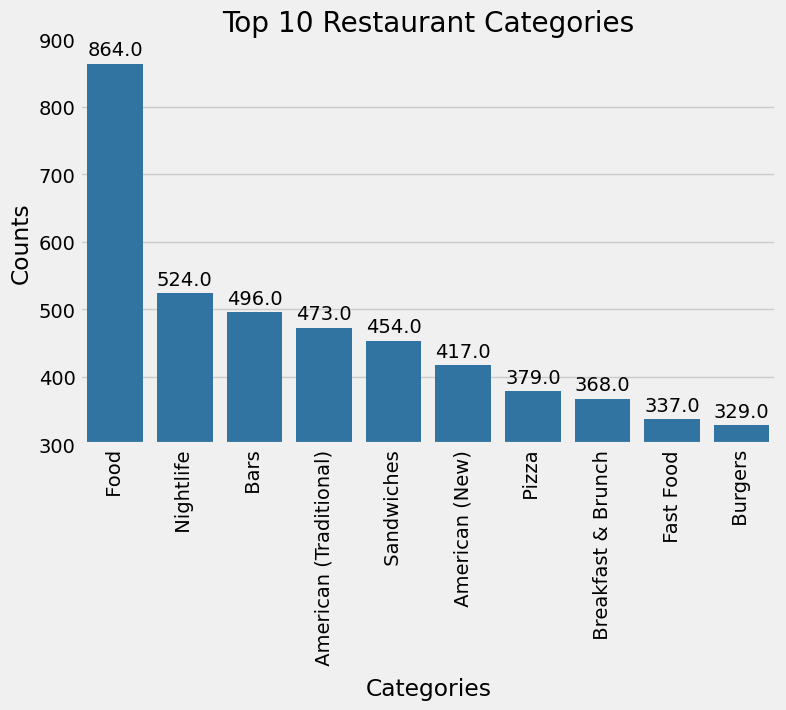

In [ ]:
# list of all categories
categories=[ cat for category in data.drop_duplicates('business_id').categories for cat in category.split(',')]
# list of unique categories only
categories=collections.Counter(categories)
#pick the top 20 categories
common=categories.most_common(12)
# plotting
fig, ax=plt.subplots(figsize=(8,5))
x=[ i[0] for i in common[2:]]
y=[i[1] for i in common[2:]]
sns.barplot(x=x, y=y, color='tab:blue', ax=ax)
ax.set_xlabel("Categories")
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Counts")
ax.set_ylim([300,900])
ax.set_title("Top 10 Restaurant Categories");
ax.bar_label( ax.containers[0], padding=3, fmt='{:,}');

[Text(3, 0, '441.0'),
 Text(3, 0, '212.0'),
 Text(3, 0, '199.0'),
 Text(3, 0, '189.0'),
 Text(3, 0, '178.0'),
 Text(3, 0, '166.0'),
 Text(3, 0, '145.0'),
 Text(3, 0, '138.0'),
 Text(3, 0, '103.0'),
 Text(3, 0, '57.0')]

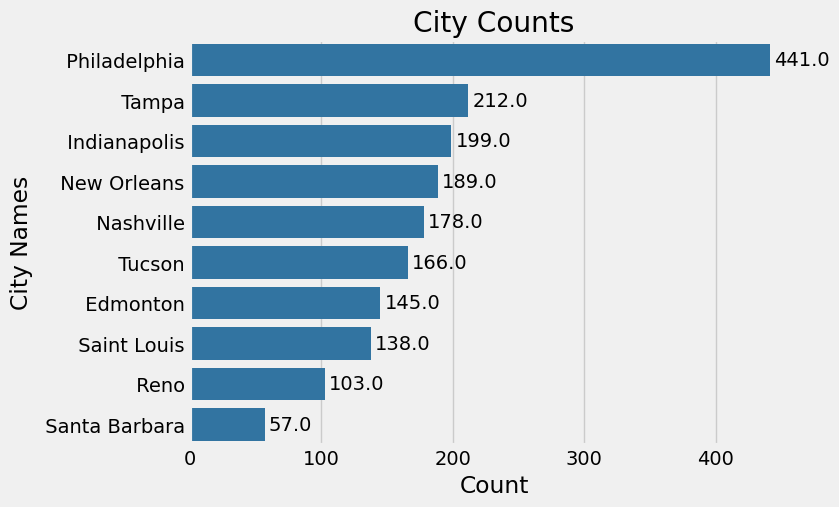

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Drop duplicate businesses and keep the 'address' column
location = data.drop_duplicates('business_id')[['location']]

# Extract city from address
city = location.location.dropna().apply(lambda x: x.split(',')[1].replace("City:", '') if ',' in x else 'Unknown')

# Count cities
city_counts = Counter(city).most_common(10)
y = [i[0] for i in city_counts]
x = [i[1] for i in city_counts]

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(y=y, x=x, color='tab:blue')
ax.set_ylabel("City Names")
ax.set_xlabel("Count")
ax.set_title("City Counts")
ax.bar_label(ax.containers[0], padding=3, fmt='{:,}')

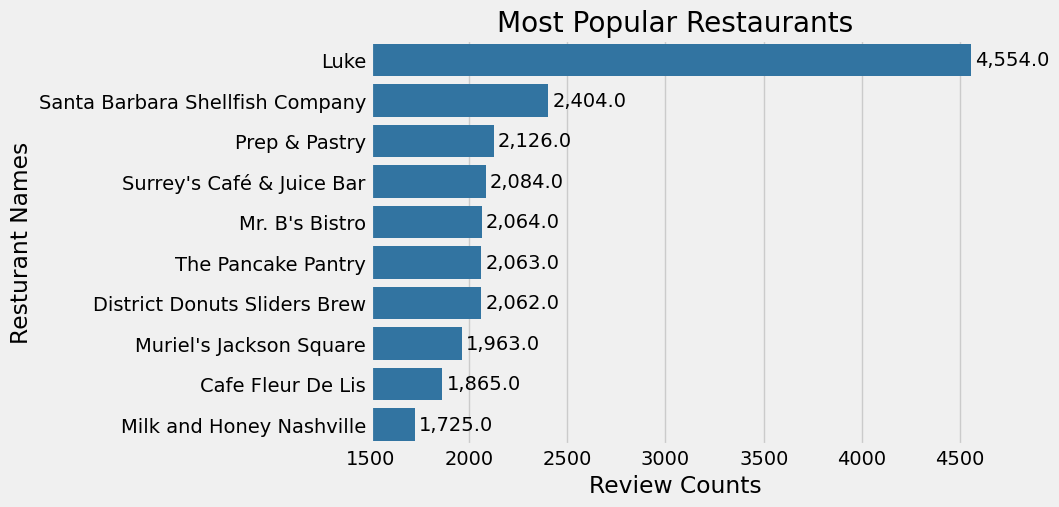

In [ ]:
# most popular restaurants

index=data.drop_duplicates(subset='business_id').sort_values(by=['review_count','b/s_rating'],ascending=False)[:10].index

fig, ax=plt.subplots(figsize=(7,5))
sns.barplot(data=data.loc[index], x="review_count", y='name', color='tab:blue')
ax.set_ylabel("Resturant Names")
ax.set_xlabel("Review Counts")
ax.set_xlim([1500,4600])
ax.set_title("Most Popular Restaurants");
ax.bar_label( ax.containers[0],padding=3, fmt='{:,}');

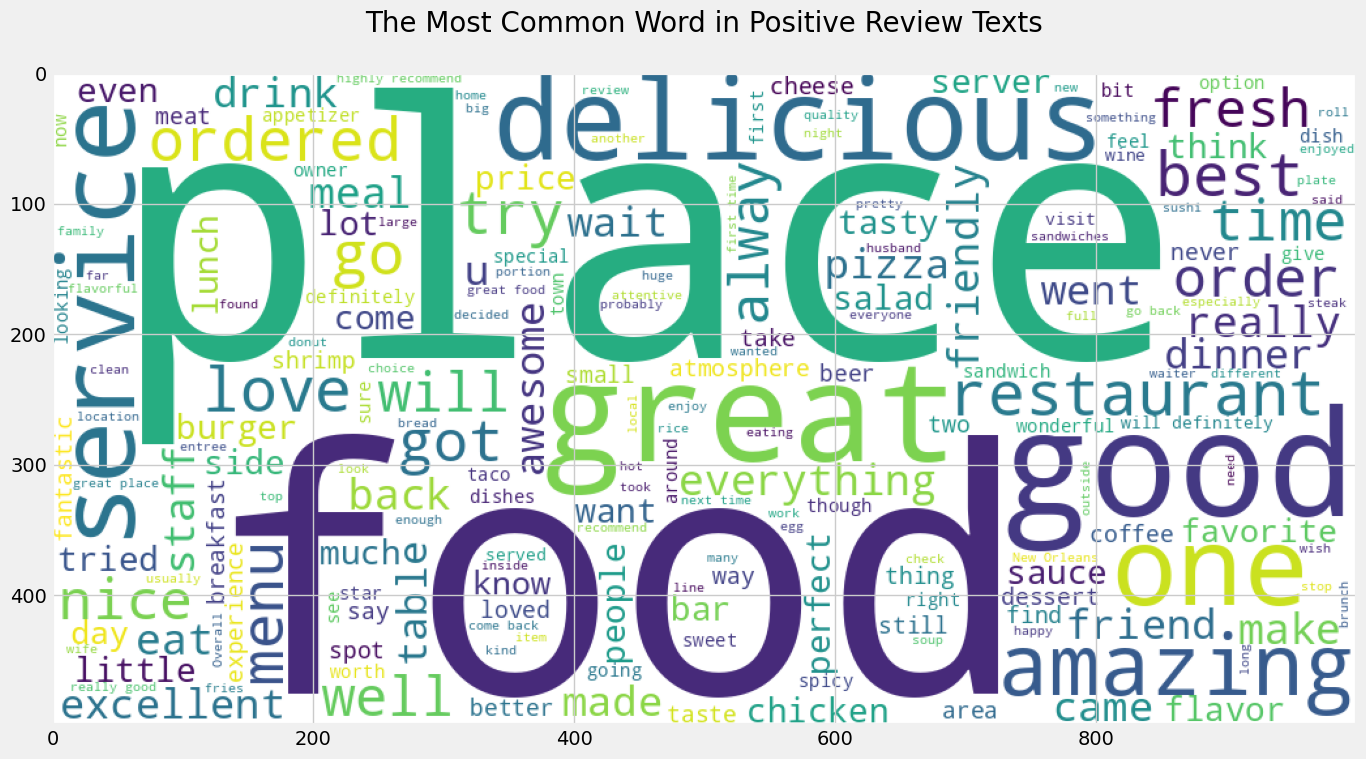

In [ ]:
# create a word count plot for the positive reviews

# select only positive reviews is reviews with 4 and above ratings
df=data.loc[ (data['rating']>=4)& (data['b/s_rating']>=4)]

# create the plot figure
plt.figure(figsize=(15,15))

plt.title('The Most Common Word in Positive Review Texts\n', fontsize=20)  # setting plot title

# create the plot on only the most 200 words and setting the plot size
wc = WordCloud(max_words=200, min_font_size=10,height=500,width=1000,background_color="white")\
        .generate(' '.join(df['text'])) #create a WordCloud using the text review column

plt.imshow(wc);

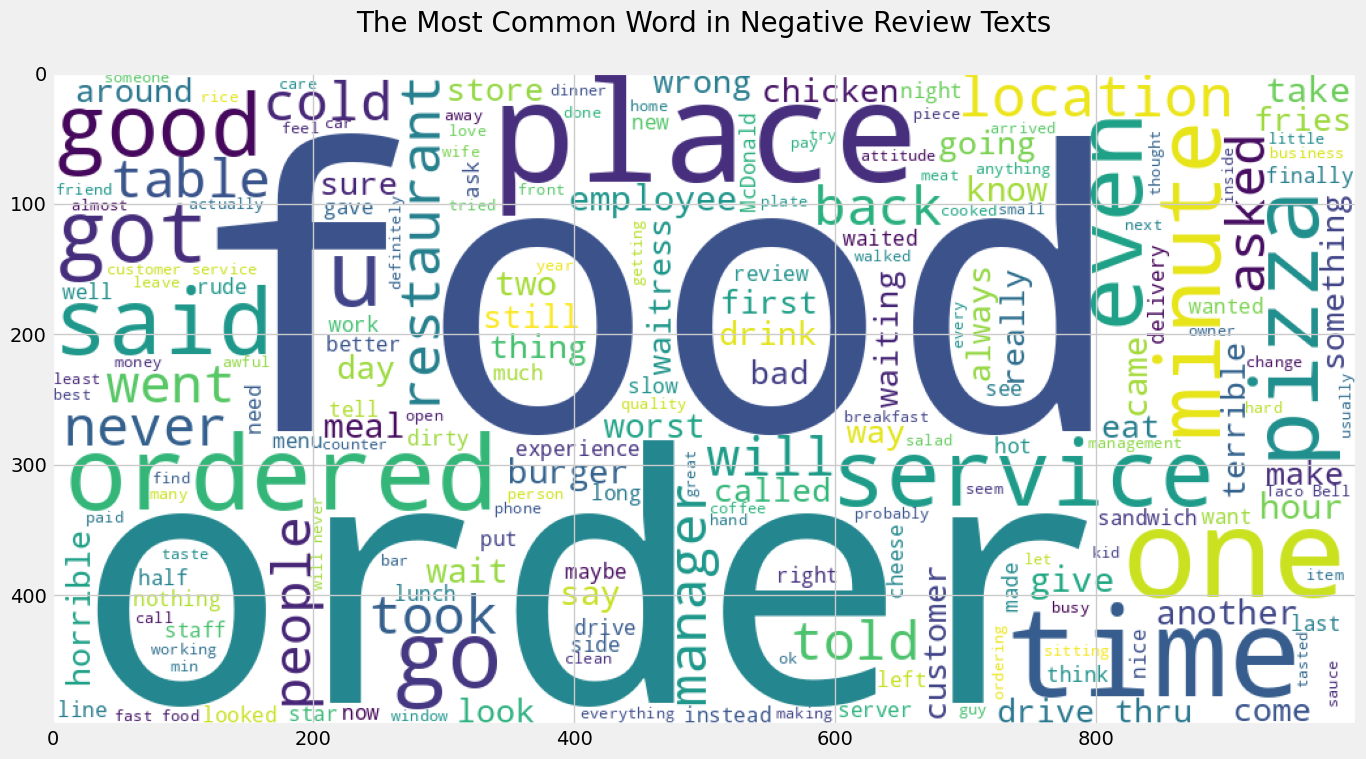

In [ ]:
# create a word count plot for the positive reviews

# select only negative reviews i.e reviews with 2 and below ratings
df=data.loc[ (data['rating']<=2)& (data['b/s_rating']<=2)]
plt.figure(figsize=(15,15))

# create the plot figure
plt.title('The Most Common Word in Negative Review Texts\n', fontsize=20)


# create the plot on only the most 200 words and setting the plot size
wc = WordCloud(max_words=200,height=500,width=1000,background_color="white")\
        .generate(' '.join(df['text']))    #create a WordCloud using the text review column

plt.imshow(wc);

In [ ]:
# Set up center latitude and longitude
center_lat = data['latitude'][0]
center_long = data['longitude'][0]

# Initialize map with center lat and long
map_ = folium.Map([center_lat, center_long], zoom_start=5)

# Adjust this limit to see more or fewer businesses
limit = 1000

for index in range(limit):
    # Extract information about business
    lat = data.loc[index, 'latitude']
    long = data.loc[index, 'longitude']
    name = data.loc[index, 'name']
    rating = data.loc[index, 'b/s_rating']
    address = data.loc[index, 'location']  # fixed line

    # Create details string
    details = f"{name}<br>Rating: {rating}<br>Address: {address}"

    # Create popup and marker
    popup = folium.Popup(details, parse_html=True)
    marker = folium.Marker(location=[lat, long], popup=popup)
    marker.add_to(map_)

map_

In [ ]:
# create a function that aggregates/combines all the extra reviews made to a particular restaurant into one text

def new_df(data):
    """
    The function takes in a dataframes and groups it by business_id column then combines all the text values in the
    text column into one big text then assigns it to the review column

    """
    # drop duplicates based on business_id and reset the index
    df = data.drop_duplicates('business_id').reset_index(drop=True)

    # loop through unique business_id values
    for id in data.business_id.unique():
    # extract text for each unique business_id and explode it into separate rows
        text = data.loc[data.business_id == id, 'text'].explode(ignore_index=True)
    # join the exploded text into a single string
        text = ' '.join(text)

    # assign the concatenated text to the reviews column for the corresponding business_id
        df.loc[data.business_id == id, 'reviews'] = text

    return df

# call the function and create the new df
df = new_df(data)
df.head()

,business_id,rating,text,name,latitude,longitude,b/s_rating,review_count,attributes,categories,hours,location,user_id,price,reviews
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,40.210196,-75.223639,3.0,169,"{'NoiseLevel': ""u'average'"", 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","State:PA, City:North Wales, Address:1460 Bethl...",1,2,"If you decide to eat here, just be aware it is..."
1,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,32.207233,-110.980864,3.5,47,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",Not-Available,"State:AZ, City:Tucson, Address:748 W Starr Pas...",3,1,Family diner. Had the buffet. Eclectic assortm...
2,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",Zaika,40.079848,-75.025080,4.0,181,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","State:PA, City:Philadelphia, Address:2481 Gran...",4,2,"Wow! Yummy, different, delicious. Our favo..."
3,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,Melt,29.962102,-90.087958,4.0,32,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","State:LA, City:New Orleans, Address:2549 Banks...",5,2,Cute interior and owner (?) gave us tour of up...
4,04UD14gamNjLY0IDYVhHJg,1.0,I am a long term frequent customer of this est...,Dmitri's,39.938013,-75.148131,4.0,273,"{'BusinessParking': ""{'garage': False, 'street...","Mediterranean, Restaurants, Seafood, Greek","{'Wednesday': '17:30-21:0', 'Thursday': '17:30...","State:PA, City:Philadelphia, Address:795 S 3rd...",6,2,I am a long term frequent customer of this est...


In [ ]:
# decompress the attributes column into  new 'attributes_true' column

def decompress(x):
    """
    The function takes in a dictionary and returns only the keys that have their values not being False
    """

    list_ = []
# evaluate the attributes column to convert it from a string to a dictionary
    data_dict = eval(x)

# iterate through the key-value pairs in the dictionary
    for key, val in data_dict.items():
# check if the key is in the specified categories and if the value is not "None"
        if (key in ['Ambience', 'GoodForMeal', 'BusinessParking']) and (val != "None"):
# if conditions are met, further iterate through sub-dictionary
            for key_, val_ in eval(data_dict[key]).items():
# if the sub-dictionary value is true, append it to the list
                if val_:
                    list_.append(f'{key}_{key_}')
        else:
# if the value is not false, append the key to the list
            if val != 'False':
                list_.append(key)

# join the list of selected attribute names into a space-separated string
    return " ".join(list_)

# create a new column 'attributes_true' in the df by applying the decompress function
# include a condition to handle cases where attributes is 'Not-Available'
df['attributes_true'] = df.attributes.apply(lambda x: decompress(x) if x != 'Not-Available' else ' ')


In [ ]:
# confirm if the newly created column has performed as expected

print("Before:")
print(eval(df.attributes[0]))
print('\n After:')
df['attributes_true'][0]      # Print the result for the first row of 'attributes'

Before:
{'NoiseLevel': "u'average'", 'HasTV': 'False', 'RestaurantsAttire': "'casual'", 'BikeParking': 'False', 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}", 'WiFi': "'free'", 'DogsAllowed': 'False', 'Alcohol': "'none'", 'BusinessAcceptsCreditCards': 'True', 'RestaurantsGoodForGroups': 'True', 'RestaurantsPriceRange2': '2', 'RestaurantsReservations': 'False', 'WheelchairAccessible': 'True', 'BusinessAcceptsBitcoin': 'False', 'RestaurantsTableService': 'True', 'GoodForKids': 'True', 'Caters': 'False', 'HappyHour': 'False', 'RestaurantsDelivery': 'True', 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}", 'OutdoorSeating': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"}

 After:


'NoiseLevel RestaurantsAttire Ambience_casual WiFi Alcohol BusinessAcceptsCreditCards RestaurantsGoodForGroups RestaurantsPriceRange2 WheelchairAccessible RestaurantsTableService GoodForKids RestaurantsDelivery GoodForMeal_lunch GoodForMeal_brunch GoodForMeal_breakfast OutdoorSeating RestaurantsTakeOut BusinessParking_lot'

In [ ]:
# merge different columns to form one column of text
df['details']=df[['attributes_true','categories','reviews']].apply(lambda x: ''.join(x), axis=1)

# preview the first row value in the new column
df.details[0]

# drop columns
df.drop(columns=['attributes_true','reviews'], inplace=True)

In [ ]:
# first create a pattern that strips all the non-word characters from words during tokenization
pattern =r"(?u)\b\w\w+\b"

# instantiate the tokenizer
tokenizer = RegexpTokenizer(pattern)

# instantiate the stemmer
stemmer = SnowballStemmer(language="english")

# create a function to tokenize and stem words
def stem_and_tokenize(list_):
    tokens = tokenizer.tokenize(list_)
    return [stemmer.stem(token) for token in tokens]

In [ ]:
# instantiate the stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


# instantiate the stop words
stopwords=stopwords.words('english')
# stemming the stopwords for uniformity while removing stopwords
stopwords=[ stemmer.stem(i) for i in stopwords]


tfidf = TfidfVectorizer( max_features=200 ,
                        stop_words=stopwords,
                        tokenizer= stem_and_tokenize
#                         ngram_range=(1, 2),
#                         min_df=0,
                        )


# fitting and transforming the details column to extract the top 200 features
tfidf_matrix=tfidf.fit_transform(df['details'])

# preview the tfidf matrix
pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf.get_feature_names_out()).head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,also,alway,amaz,anoth,appet,area,around,ask,atmospher,attent,...,walk,want,way,well,went,wine,wonder,work,worth,would
0,0.030917,0,0.033784,0.14895,0,0.07106,0,0.067906,0,0.040761,...,0,0.032251,0.068911,0.031813,0.033654,0,0,0,0.037926,0.059517
1,0.075967,0,0,0,0,0.043651,0,0.041713,0.046024,0.100155,...,0.046288,0,0.042331,0.039084,0.041346,0,0,0.091133,0,0.146242
2,0.030903,0.066009,0.067537,0.01861,0.022747,0.088784,0.05351,0,0.018722,0.020371,...,0,0.064471,0.01722,0.079496,0.084095,0.026438,0.020262,0.055608,0.056862,0.074362
3,0.06169,0,0,0,0,0.070894,0,0,0,0,...,0,0,0.06875,0.063478,0.067151,0.316666,0,0,0,0.059378
4,0.046791,0.266525,0.068173,0.037571,0.091846,0,0,0.034257,0,0.020563,...,0,0.032539,0.034764,0.016049,0.050933,0.053375,0.102267,0.018711,0.038265,0.090075


In [ ]:
# create a matrix of the cosine similarities of the various rows based on the tidf scores
cosine_similarity=cosine_similarity(tfidf_matrix)
print("shape: ",cosine_similarity.shape)

# view the first column
cosine_similarity[0]

shape:  (3720, 3720)


array([1.        , 0.56019903, 0.52164205, ..., 0.50178735, 0.59844529,
       0.4746701 ])

In [ ]:
import os

# Create the 'data' directory if it doesn't exist
if not os.path.exists('./data'):
    os.makedirs('./data')

# saving our data for deployment
pickle.dump(tfidf_matrix, open('./data/tfidf_matrix.pkl', 'wb'))
pickle.dump(cosine_similarity, open('./data/cosine_similarity.pkl', 'wb'))
pickle.dump(df, open('./data/data.pkl', 'wb'))
print("Files saved...")

with open('./data/cosine_similarity.pkl', 'rb') as file:
    cosine_similarity=pickle.load(file)

with open('./data/data.pkl', 'rb') as file:
    df=pickle.load(file)

Files saved...


In [ ]:
# creating a folium_map function that displays restaurant lovations

def folium_map(data):
    """
    The function takes in a dataframe and using the latitude and longitude columns displays a map showing the locations of
    all the restaurants available in the input data
    """
    # reseting the index in the input dataframe
    dff=data.reset_index(drop=True)


# Set up center latitude and longitude
    center_lat = dff['latitude'][0]
    center_long = dff['longitude'][0]

# Initialize map with center lat and long
    map_ =folium.Map([center_lat,center_long], zoom_start=7)

# Adjust this limit to see more or fewer businesses
    limit=dff.shape[0]
    print(f"{limit-1} Restaurant Locations")
    for index in range(limit-1):
        # Extract information about business
        lat = dff.loc[index,'latitude']
        long = dff.loc[index,'longitude']
        name = dff.loc[index,'name']
        rating = dff.loc[index,'b/s_rating']
        location = dff.loc[index,'location']
        details = "{}\nStars: {} {}".format(name,rating,location)

# Create popup with relevant details
        popup = folium.Popup(details,parse_html=True)

# Create marker with relevant lat/long and popup
        marker = folium.Marker(location=[lat,long], popup=popup)

        marker.add_to(map_)

In [ ]:
def content_based(df=df, name:str= None , rating:int =1, num:int=5, text: str=None, location:str = None):
    """
    The function takes the following input;

    df: DataFrame - a dataframe containing unique resturants
    name: str - name of restaurant to recommend similar restaurants
    num:int - number of restaurants to recommend
    location: string - preferred location
    rating: string - preferred rating of restaurant
    text: - User preferences inform of text

    Then based on the input parameters offers similar restaurants according to the input parameters to users
    """

    if name:
        index_=df.loc[df.name== name].index[0]                          # find the index of the input name
        sim=list(enumerate(cosine_similarity[index_]))                  # extract similarity vector of that name index
        sim=sorted(sim, key=lambda x: x[1], reverse=True)[1:num+1]      # arrange the vector values in ascending order
        indices= [i[0] for i in sim]                                    # Extract the indices of the top high scores
        print(f"Top {num} Restaurants Like [{name}]")

        # if the location parameter is passed then the dataframe is filtered based on the input location
        if location:
            df=df.loc[ (df['b/s_rating']>=rating) & ( df.location.str.contains(location))]
            folium_map(df)
        else:
            df= df.loc[ (df['b/s_rating']>=rating) ]
        # filtering the data based on the selected indices

    # if the name is None then switch to other parameters
    else:
        # if the text has a passed input values then this if statement runs
        if text:
                text=text.lower()                                           # converting the text into lowercase
                tokens=stem_and_tokenize(text)                              # tokenizing and stemming the words
                tokens=[ word for word in tokens if word not in stopwords]  # removing stopwords
                text_set=set(tokens)                                        # taking only unique words

                if location: # using entered location to filter the data
                    df=df.loc[ (df.location.str.contains(location)) & (df['b/s_rating']>=rating)].reset_index(drop=True)

                vectors=[] # creating an emplty list to append the intersection values
                for words in df.details:                                     # looping over the text in the details column
                    words=words.lower()                                      # lowering the text
                    words=stem_and_tokenize(text)                            # tokenizing and stemming the words
                    words=[ word for word in tokens if word not in stopwords] # removing stopwords
                    words=set(words)                                         # taking only unique words
                    vector=text_set.intersection(words)                      # checking for intersection with entered text
                    vectors.append(len(vector))                              # appending value to vectors list

                vectors=sorted(list(enumerate(vectors)), key= lambda x: x[1], reverse=True)[:num] # sorting the list in desc
                indices= [i[0] for i in vectors]                                         # selecting indices of top values
                print(f"Top {num} Best Restaurants Based on entered text:")
                # using the indices fileter the dataframe
                df=df.loc[indices].sort_values(by=['b/s_rating','review_count'],ascending=False)
                if location: folium_map(df)                                   # calling the folim_map of the selected values
                return df[['name','b/s_rating','review_count','location']].reset_index(drop=True) # offering recommendations

        # the if only location is entered as a parameter then the top businesses in that location are recommended
        if location:
            df=df.loc[ df.location.str.contains(location)& (df['b/s_rating']>=rating)] #filtering dataframe
            df=df.sort_values(['review_count','b/s_rating'])[:num]     # sorting in descending order
            folium_map(data=df)
            return df[['name','b/s_rating','review_count','location']].reset_index(drop=True) # offering recommendations

        # if both the name, text and location are None the most popular restaurants are recommended
        else:
            df=df.loc[data['b/s_rating']>=rating].sort_values(by=['review_count','b/s_rating'],ascending=False)[:num]
            df = df[['name', 'b/s_rating', 'review_count']]
            if 'location' in df.columns:
                df = df[['name', 'b/s_rating', 'review_count', 'location']]  # include 'location' if present
            if location: folium_map(data=df)
            print("Most Popular Restaurants")
            return df.reset_index(drop=True)



In [ ]:
# running the recommender on default parameters
content_based()

Most Popular Restaurants


,name,b/s_rating,review_count
0,Luke,4.0,4554
1,Santa Barbara Shellfish Company,4.0,2404
2,Prep & Pastry,4.5,2126
3,Surrey's Café & Juice Bar,4.5,2084
4,Mr. B's Bistro,4.0,2064


In [ ]:
# Recommending restaurants with attributes in the entered text
content_based(text="I want a clean restaurant with good dessert and parking space and a nice environment")

Top 5 Best Restaurants Based on entered text:


,name,b/s_rating,review_count,location
0,Dmitri's,4.0,273,"State:PA, City:Philadelphia, Address:795 S 3rd..."
1,Zaika,4.0,181,"State:PA, City:Philadelphia, Address:2481 Gran..."
2,Melt,4.0,32,"State:LA, City:New Orleans, Address:2549 Banks..."
3,Kettle Restaurant,3.5,47,"State:AZ, City:Tucson, Address:748 W Starr Pas..."
4,Turning Point of North Wales,3.0,169,"State:PA, City:North Wales, Address:1460 Bethl..."


**Collaborative Filtering Models**

User-item based filtering

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Recreate new_df properly
new_df = data[['user_id', 'business_id', 'rating']]


# Pivot for item-item CF
item_user_matrix = new_df.pivot_table(index='business_id', columns='user_id', values='rating').fillna(0)

# Cosine similarity
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

print('Number of Restaurants:', item_user_matrix.shape[0])
print('Number of users:', item_user_matrix.shape[1])

Number of Restaurants: 3720
Number of users: 34497


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Step 1: Prepare user-item matrix
df = data[['user_id', 'business_id', 'rating']]
user_item_matrix = df.pivot_table(index='user_id', columns='business_id', values='rating')

# Fill NaNs with 0 temporarily for similarity computation
item_user_matrix = user_item_matrix.T.fillna(0)

# Step 2: Compute cosine similarity between items
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

# Step 3: Prediction function
def predict_rating(user_id, item_id, k=10):
    try:
        if item_id not in item_similarity_df.columns or user_id not in user_item_matrix.index:
            return np.nan

        user_rated_items = user_item_matrix.loc[user_id].dropna()
        if len(user_rated_items) == 0:
            return np.nan

        valid_items = item_similarity_df.index.intersection(user_rated_items.index)
        if item_id not in valid_items:
            return np.nan

        similarities = item_similarity_df.loc[valid_items, item_id]
        top_k = similarities.sort_values(ascending=False).head(k)

        ratings = user_rated_items[top_k.index]
        if top_k.sum() == 0 or len(ratings) == 0:
            return ratings.mean()

        pred = np.dot(top_k.values, ratings.values) / np.sum(np.abs(top_k.values))
        return pred
    except:
        return np.nan

# Step 4: Cross-validation evaluation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
mae_scores = []
precisions = []
recalls = []
accuracies = []

top_k = 10
threshold = 4.0

print("Evaluating with 5-Fold CV...\n")

for train_index, test_index in tqdm(kf.split(user_item_matrix), total=5):
    train_users = user_item_matrix.iloc[train_index]
    test_users = user_item_matrix.iloc[test_index]

    preds, actuals = [], []

    for user_id in test_users.index:
        user_ratings = user_item_matrix.loc[user_id].dropna()
        pred_ratings = {}

        for item_id in user_ratings.index:
            actual_rating = user_ratings[item_id]
            pred_rating = predict_rating(user_id, item_id, k=10)
            if not np.isnan(pred_rating):
                preds.append(pred_rating)
                actuals.append(actual_rating)
                pred_ratings[item_id] = pred_rating

        # Precision/Recall/Accuracy@K
        if pred_ratings:
            sorted_items = sorted(pred_ratings.items(), key=lambda x: x[1], reverse=True)
            top_items = [item for item, _ in sorted_items[:top_k]]

            relevant_items = user_ratings[user_ratings >= threshold].index.tolist()
            hits = set(top_items).intersection(relevant_items)

            precision = len(hits) / top_k if top_k > 0 else 0
            recall = len(hits) / len(relevant_items) if relevant_items else 0
            accuracy = sum([
                (pred_ratings[i] >= threshold and user_ratings[i] >= threshold) or
                (pred_ratings[i] < threshold and user_ratings[i] < threshold)
                for i in top_items if i in user_ratings
            ]) / len(top_items) if top_items else 0

            precisions.append(precision)
            recalls.append(recall)
            accuracies.append(accuracy)

    # Calculate RMSE and MAE for this fold
    if preds:
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = mean_absolute_error(actuals, preds)
        rmse_scores.append(rmse)
        mae_scores.append(mae)

# Step 5: Print Evaluation Summary
print("\n----------------------------")
print("Evaluation Summary (Item-based Cosine KNN)")
print(f"Mean RMSE         : {np.mean(rmse_scores):.4f}")
print(f"Mean MAE          : {np.mean(mae_scores):.4f}")
print(f"Mean Precision@{top_k}: {np.mean(precisions):.4f}")
print(f"Mean Recall@{top_k}   : {np.mean(recalls):.4f}")
print(f"Mean Accuracy      : {np.mean(accuracies):.4f}")
print("----------------------------")


Evaluating with 5-Fold CV...



100%|██████████| 5/5 [01:12<00:00, 14.48s/it]


----------------------------
Evaluation Summary (Item-based Cosine KNN)
Mean RMSE         : 0.0813
Mean MAE          : 0.0192
Mean Precision@10: 0.0778
Mean Recall@10   : 0.7084
Mean Accuracy      : 0.9877
----------------------------


In [ ]:
import pandas as pd
import numpy as np

def get_top_recommendations(user_id, data, item_similarity_df, user_item_matrix, top_n=5, rating_threshold=3.5):
    """
    Returns top-N recommended items for a given user using item-based collaborative filtering.

    Parameters:
    - user_id: str, the target user
    - data: original dataframe containing restaurant info
    - item_similarity_df: precomputed item-item similarity matrix
    - user_item_matrix: pivot table of user-item ratings
    - top_n: number of top recommendations
    - rating_threshold: minimum predicted rating to consider

    Returns:
    - DataFrame of top recommended restaurants with predicted ratings
    """

    # Ensure user_id is string and index is consistent
    user_id = str(user_id)
    user_item_matrix.index = user_item_matrix.index.astype(str)

    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in dataset.")
        return pd.DataFrame()

    all_items = set(user_item_matrix.columns)
    rated_items = set(user_item_matrix.loc[user_id].dropna().index)
    items_to_predict = list(all_items - rated_items)

    predictions = []

    for item_id in items_to_predict:
        pred_rating = predict_rating(user_id, item_id, item_similarity_df, user_item_matrix, k=10)
        if not np.isnan(pred_rating) and pred_rating >= rating_threshold:
            predictions.append((item_id, pred_rating))

    top_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]



    if not top_preds:
      fallback = (
        data[~data['business_id'].isin(rated_items)]
        .sort_values(by='b/s_rating', ascending=False)
        .drop_duplicates(subset='business_id')
        .head(top_n)
    )
    return fallback[['business_id', 'name', 'categories', 'location', 'b/s_rating']]




    recommended_ids = [item_id for item_id, _ in top_preds]
    predicted_scores = [score for _, score in top_preds]

    recommended_df = data[data['business_id'].isin(recommended_ids)][['business_id', 'name', 'categories', 'location', 'b/s_rating']]
    recommended_df = recommended_df.set_index('business_id').loc[recommended_ids].reset_index()
    recommended_df['predicted_rating'] = predicted_scores

    return recommended_df


In [ ]:
def predict_rating(user_id, item_id, item_similarity_df, user_item_matrix, k=10):
    """
    Predict rating for a given user and item using item-based collaborative filtering.
    """
    if item_id not in item_similarity_df.columns:
        return np.nan

    similar_items = item_similarity_df[item_id].drop(item_id).dropna()
    user_ratings = user_item_matrix.loc[user_id].dropna()

    common_items = user_ratings.index.intersection(similar_items.index)

    if len(common_items) == 0:
        return np.nan

    # Top-k similar items rated by the user
    top_k_items = similar_items.loc[common_items].sort_values(ascending=False).head(k)
    top_k_ratings = user_ratings.loc[top_k_items.index]

    numerator = np.dot(top_k_items, top_k_ratings)
    denominator = np.abs(top_k_items).sum()

    if denominator == 0:
        return np.nan

    return numerator / denominator


In [ ]:
top_recs = get_top_recommendations(
    user_id=6,
    data=data,
    item_similarity_df=item_similarity_df,
    user_item_matrix=user_item_matrix,
    top_n=5
)



In [ ]:
from tabulate import tabulate

# Assuming `recommendations` is your final DataFrame
print("Top 5 restaurant recommendations for user:\n")
print(tabulate(top_recs, headers='keys', tablefmt='pretty'))


Top 5 restaurant recommendations for user:

+-------+------------------------+----------------------------------------+------------------------------------------------------------------------------------+--------------------------------------------------------+------------+
|       |      business_id       |                  name                  |                                     categories                                     |                        location                        | b/s_rating |
+-------+------------------------+----------------------------------------+------------------------------------------------------------------------------------+--------------------------------------------------------+------------+
| 28991 | _aKr7POnacW_VizRKBpCiA |            Blues City Deli             |   Delis, Bars, Restaurants, Nightlife, Pubs, American (Traditional), Sandwiches    |  State:MO, City:Saint Louis, Address:2438 McNair Ave   |    5.0     |
| 3366  | U0zDLXmqyUwRnPrF8KCepQ